In [1]:
import sys
sys.path.append("../code")

from data import FloatingSeaObjectDataset
from torch.utils.data import DataLoader
from model import UNet
import matplotlib.pyplot as plt
from transforms import get_transform
data_path = "/ssd/floatingObjects/data"
device = "cpu"
import torch
        
import numpy as np

image_size = 128
valid_dataset = FloatingSeaObjectDataset(data_path, fold="val", transform=get_transform("test"),
                                         output_size=image_size, seed=0, hard_negative_mining=False)
dl = DataLoader(valid_dataset, shuffle=True)



In [2]:
!ls /ssd/floatingObjects/models/0

events.out.tfevents.1611938801.marc-tower.211402.0
events.out.tfevents.1611939548.marc-tower.213384.0
loss_train
loss_val
manet-posweight10-lr001-aug2r.pth.tar
manet-posweight10-lr01-aug2.pth.tar
manet-posweight10-lr01-aug2r.pth.tar
manet-posweight5-lr01-aug2r.pth.tar
resnetunet-posweight10-lr01-aug2.pth.tar
resnetunetscse-posweight10-lr01-aug1-scratch.pth.tar
resnetunetscse-posweight10-lr01-aug2.pth.tar
run_arguments_0.json
unet-posweight10-lr01-aug2.pth.tar


In [88]:
rightmodel = UNet(n_channels=12,
             n_classes=1,
             bilinear=False).to(device)
snapshot = torch.load("/ssd/floatingObjects/models/0/unet-posweight10-lr001-aug1.pth.tar", map_location="cpu")
rightmodel.load_state_dict(snapshot["model_state_dict"])
rightmodel.eval()

leftmodel = UNet(n_channels=12,
             n_classes=1,
             bilinear=False).to(device)
snapshot = torch.load("/ssd/floatingObjects/models/model_posweight5.pth.tar", map_location="cpu")
leftmodel.load_state_dict(snapshot["model_state_dict"])
leftmodel.eval()
#snapshot = torch.load("/ssd/floatingObjects/models/model_posweight5.pth.tar", map_location="cpu")
#snapshot = torch.load("/ssd/floatingObjects/models/model_posweight5_chshfl.pth.tar", map_location="cpu")


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

In [51]:
#import segmentation_models_pytorch as smp
#model = smp.Unet(
#    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#    encoder_weights=None,
#    in_channels=12,  # model input channels (1 for grayscale images, 3 for RGB, etc.)
#    classes=1,  # model output channels (number of classes in your dataset)
#)

#snapshot = torch.load("/ssd/floatingObjects/models/newmodel.pth.tar", map_location="cpu")
#model.load_state_dict(snapshot["model_state_dict"])

In [59]:
from tqdm import tqdm

model = rightmodel

importances = []
i = 0
for x_,y,fid in tqdm(dl):
    x = torch.tensor(x_, requires_grad=True)
    y = torch.tensor(y)
    y_pred = model(x).squeeze()
    mean_pred = y_pred.view(-1)[y.view(-1).bool()].mean()
    mean_pred.backward()
    importances.append(x.grad.squeeze().mean([1,2]).numpy())
    i+=1
    if i > 200:
        break

importances = np.stack(importances)

  0%|          | 0/1626 [00:00<?, ?it/s]<ipython-input-59-0fa7723ffa2b>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x_, requires_grad=True)
<ipython-input-59-0fa7723ffa2b>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
 12%|█▏        | 200/1626 [02:15<16:02,  1.48it/s]


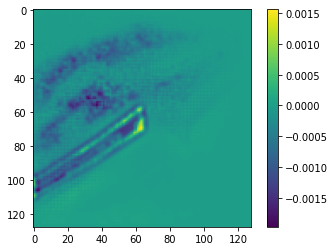

In [56]:
import matplotlib.pyplot as plt
plt.imshow(x.grad.mean([0,1]).detach())
plt.colorbar()

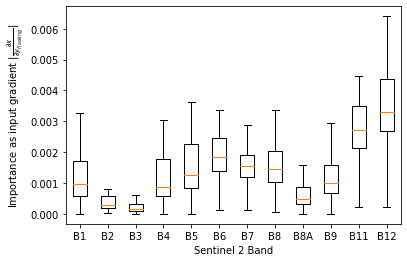

In [60]:
l2abands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"]

fig, ax = plt.subplots()
ax.boxplot(np.abs(importances), showfliers=False)
ax.set_xticks(np.arange(1,len(l2abands)+1))
ax.set_xticklabels(l2abands)
ax.set_xlabel("Sentinel 2 Band")
ax.set_ylabel(r"Importance as input gradient $\vert \frac{\partial x}{\partial y_{floating}} \vert$")
fig.savefig("bandimportance.svg")

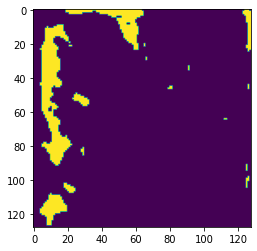

In [31]:
prediction_labels = torch.sigmoid(y_pred).detach().numpy() > 0.5
plt.imshow(prediction_labels)

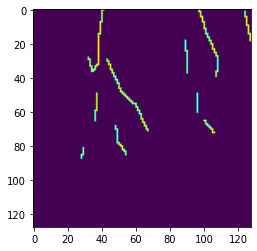

In [36]:
plt.imshow(y.view(*prediction_labels.shape))

<ipython-input-192-befe3d6a9763>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
<ipython-input-192-befe3d6a9763>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(copy(x), requires_grad=True)
<ipython-input-192-befe3d6a9763>:50: RuntimeWarning: divide by zero encountered in log10
  g2 = ax.imshow(np.log10(np.abs(grads.detach())), origin="lower", cmap="magma")


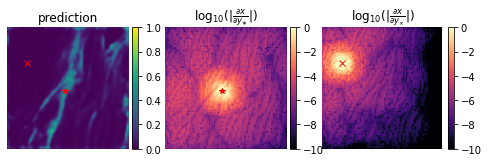

In [192]:
from visualization import s2_to_RGB
model = rightmodel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
p1 = 60,60
p2 = 20,90

x_, y, fid = valid_dataset[5]
y = torch.tensor(y)

def eval_grad(model, x, p):
    x_ = torch.tensor(copy(x), requires_grad=True)
    y_pred = model(x_.unsqueeze(0)).squeeze()
    y_pred[p[1], p[0]].mean().backward()
    return x_.grad.sum(0), y_pred # sum gradients over all bands


fig, axs = plt.subplots(1,3, figsize=(8,8))

grads, y_pred = eval_grad(model, x, p1)

ax = axs[0]
i = ax.imshow(torch.sigmoid(y_pred.detach()), origin="lower")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(i, cax=cax, orientation='vertical')
i.set_clim(0,1)

ax.plot([p1[0]],[p1[1]],'r*')
ax.plot([p2[0]],[p2[1]],'rx')
ax.axis("off")
ax.set_title("prediction")
#ax = axs[1]
#ax.imshow(y.detach(), origin="lower")
#ax.plot([r],[c],'wo')
#ax.set_title("target")
ax = axs[1]
g1 = ax.imshow(np.log10(np.abs(grads.detach())), origin="lower", cmap="magma")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(g1, cax=cax, orientation='vertical')
g1.set_clim(-10,0)

ax.set_title(r"$\log_{10}(|\frac{\partial x}{\partial y_{\ast}}|)$")
ax.plot([p1[0]],[p1[1]],'r*')
ax.axis("off")

ax = axs[2]
grads, y_pred = eval_grad(model, x, p2)
g2 = ax.imshow(np.log10(np.abs(grads.detach())), origin="lower", cmap="magma")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g2, cax=cax, orientation='vertical')
g2.set_clim(-10,0)

ax.set_title(r"$\log_{10}(|\frac{\partial x}{\partial y_{\times}}|)$")
ax.plot([p2[0]],[p2[1]],'rx')
ax.axis("off")
#ax = axs[2]
#ax.imshow(s2_to_RGB(x.detach().numpy()), origin="lower")
#ax.plot([r],[c],'rx')
fig.savefig("pixelgradientsright.svg", bbox_inches = 'tight',
    pad_inches = 0, transparent=True)

<ipython-input-192-befe3d6a9763>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(copy(x), requires_grad=True)
<ipython-input-193-8257886ef183>:37: RuntimeWarning: divide by zero encountered in log10
  g2 = ax.imshow(np.log10(np.abs(grads.detach())), origin="lower", cmap="magma")


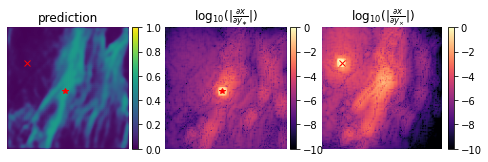

In [193]:
from visualization import s2_to_RGB
model = leftmodel
from copy import copy

fig, axs = plt.subplots(1,3, figsize=(8,8))

grads, y_pred = eval_grad(model, x, p1)

ax = axs[0]
i = ax.imshow(torch.sigmoid(y_pred.detach()), origin="lower")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(i, cax=cax, orientation='vertical')
i.set_clim(0,1)

ax.plot([p1[0]],[p1[1]],'r*')
ax.plot([p2[0]],[p2[1]],'rx')
ax.axis("off")
ax.set_title("prediction")
#ax = axs[1]
#ax.imshow(y.detach(), origin="lower")
#ax.plot([r],[c],'wo')
#ax.set_title("target")
ax = axs[1]
g1 = ax.imshow(np.log10(np.abs(grads.detach())), origin="lower", cmap="magma")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(g1, cax=cax, orientation='vertical')
g1.set_clim(-10,0)

ax.set_title(r"$\log_{10}(|\frac{\partial x}{\partial y_{\ast}}|)$")
ax.plot([p1[0]],[p1[1]],'r*')
ax.axis("off")

ax = axs[2]
grads, y_pred = eval_grad(model, x, p2)
g2 = ax.imshow(np.log10(np.abs(grads.detach())), origin="lower", cmap="magma")
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(g2, cax=cax, orientation='vertical')
g2.set_clim(-10,0)

ax.set_title(r"$\log_{10}(|\frac{\partial x}{\partial y_{\times}}|)$")
ax.plot([p2[0]],[p2[1]],'rx')
ax.axis("off")

fig.savefig("pixelgradientsleft.svg", bbox_inches = 'tight',
    pad_inches = 0, transparent=True)

In [114]:
x

AttributeError: 'Tensor' object has no attribute 'copy'

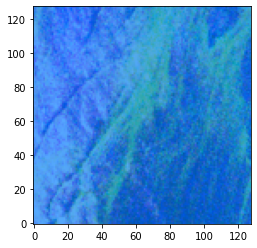